In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import pickle
import pandas

import pynumdiff

import cv2

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
directory = '/media/caveman/Vorchard11/Downloads/downsampled/p1deg'

In [3]:
v_over_d = np.load('/media/caveman/Vorchard11/Downloads/downsampled/p1deg/p1_deg.npy')

In [4]:
K = [[615.8287353515625, 0.0, 320.0995178222656],
     [0.0, 615.9053344726562, 245.37171936035156],
     [0.0, 0.0, 1.0]]
fov_x = np.arctan(320./K[0][0])*2
fov_y = np.arctan(240./K[1][1])*2

In [5]:
shape = v_over_d.shape[1:3]

alphas_x = np.linspace(-fov_x/2, fov_x/2, v_over_d.shape[2])
alphas_y = np.linspace(-fov_y/2, fov_y/2, v_over_d.shape[1])

alphas_x = np.vstack([alphas_x]*shape[0])
alphas_y = np.vstack([alphas_y]*shape[1]).T

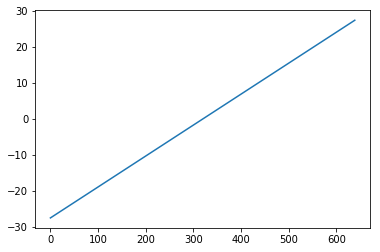

In [6]:
plt.plot(alphas_x[0,:]*180/np.pi)

In [7]:
alphas_epi = np.sign(alphas_x)*np.sqrt(alphas_x**2 + alphas_y**2)
betas = np.arctan2(alphas_x, alphas_y)

In [8]:
alphadot_x = v_over_d[:,:,:,0]*np.cos(alphas_x)*np.sin(alphas_x) # go back to alphadots
alphadot_x[np.where(np.isnan(alphadot_x))] = 0

In [9]:
alphadot_y = v_over_d[:,:,:,1]*np.cos(alphas_y)*np.sin(alphas_y)
alphadot_y[np.where(np.isnan(alphadot_y))] = 0

In [10]:
del(v_over_d)

In [11]:
def calculate_alphadot_sign(frame, alphadot_x, alphadot_y):
    return np.nanmedian(np.sign(np.gradient(np.dstack((alphadot_x[frame], alphadot_y[frame])))), axis=0)

In [ ]:
alphadot_sign = [calculate_alphadot_sign(frame, alphadot_x, alphadot_y) for frame in range(alphadot_x.shape[0])]

/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1084: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/lib/function_base.py:1091: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


In [27]:
degrees = 0.1

In [28]:
scaling = (alphas_x[0,-1] - alphas_x[0,0]) / (alphas_x[0,1] - alphas_x[0,0]) * (degrees*np.pi/180.)

In [29]:
new_shape = (int(alphadot_sign[0].shape[1]/scaling), 
             int(alphadot_sign[0].shape[0]/scaling))

IndexError: tuple index out of range

In [ ]:
def resize(a):
    return cv2.resize(a, new_shape)

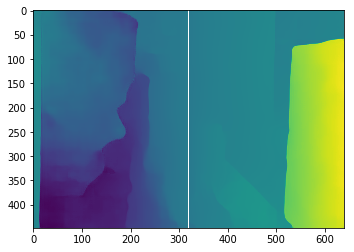

In [30]:
plt.imshow(alphadot_x[300, :,:])

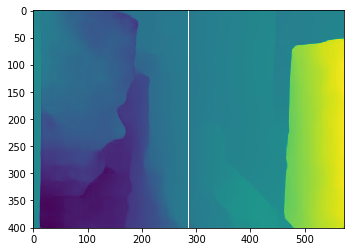

In [31]:
plt.imshow(resize(alphadot_x[300, :,:]))

In [ ]:
dfs = []
keys = []

for frame in range(alphadot_x.shape[0]):
    df = pandas.DataFrame(resize(alphadot_x[frame]))
    dfs.append(df)
    keys.append(frame)

df = pandas.concat(dfs, keys=keys)
df.to_hdf(os.path.join(directory, 'alphadot_x.hdf'), 'alphadot_x')

In [ ]:
dfs = []
keys = []

for frame in range(alphadot_y.shape[0]):
    df = pandas.DataFrame(resize(alphadot_y[frame]))
    dfs.append(df)
    keys.append(frame)

df = pandas.concat(dfs, keys=keys)
df.to_hdf(os.path.join(directory, 'alphadot_y.hdf'), 'alphadot_y')

In [ ]:
dfs = []
keys = []

for frame in range(alphadot_x.shape[0]):
    alphadot_abs = np.linalg.norm( [np.abs(alphadot_x[frame,:,:]), np.abs(alphadot_y[frame,:,:])], axis=0 )
    alphadot_sign = np.nanmean([np.sign(alphadot_x[frame,:,:]*alphas_x), np.sign(alphadot_y[frame,:,:]*alphas_y)], axis=0)
    alphadot_signed = alphadot_abs*alphadot_sign
    alphadot_signed[np.where(np.isinf(alphadot_signed))] = np.nan
    df = pandas.DataFrame(resize(alphadot_signed))
    dfs.append(df)
    keys.append(frame)

df = pandas.concat(dfs, keys=keys)
df.to_hdf(os.path.join(directory, 'alphadot_signed.hdf'), 'alphadot_signed')

In [ ]:
dfs = [pandas.DataFrame(resize(alphas_x)), 
       pandas.DataFrame(resize(alphas_y)), 
       pandas.DataFrame(resize(alphas_epi))]
keys = ['alphas_x', 'alphas_y', 'alphas_epi']

df = pandas.concat(dfs, keys=keys)
df.to_hdf(os.path.join(directory, 'alphadot_meta.hdf'), 'alphadot_meta')

# velocity and acceleration

In [ ]:
initial_idx = 0
vel = np.load('/home/caveman/Downloads/full_data/gt_velocity.npy')
vel = vel[initial_idx+1+2:-3]

In [ ]:
accel = np.load('/home/caveman/Downloads/full_data/1d_accel.npy')
accel = accel[initial_idx+1+2:-3]

In [ ]:
dt = 0.033333333
t = np.linspace(0, dt*len(accel), len(accel))

dt_alphadot = 0.2
scaling = dt_alphadot/dt

# smooth accel
params = [2, 0.04]
a_smooth_1, j_hat = pynumdiff.smooth_finite_difference.butterdiff(accel, dt, params)
a_smooth_2, _ = pynumdiff.kalman_smooth.constant_acceleration(accel, dt, [1e-2, 1e-2])

In [ ]:
dfs = [pandas.DataFrame(vel), 
       pandas.DataFrame(accel), 
       pandas.DataFrame(a_smooth_1),
       pandas.DataFrame(a_smooth_2),
       pandas.DataFrame(t),
       pandas.DataFrame([dt]),
       pandas.DataFrame([scaling]),
       pandas.DataFrame(alphadot_sign)]
keys = ['velocity_true', 'accel_measured', 'accel_smooth_1', 
        'accel_smooth_2', 'time', 'dt', 'scaling', 'sign_alphadot']

df = pandas.concat(dfs, keys=keys)
df.to_hdf(os.path.join(directory, 'vel_accel_time.hdf'), 'vel_accel_time')